In [1]:
data_path = '/home/lea/Documents/obsidian_notes/masterADS/ads_thesis_RIFT'
trial_info_file = '/A0_kabir/converted/trialinfo_matrix_A0_cleanedtrials.mat'
data_file = '/A0_kabir/Experimental/data.mat'
epoch_file = '/my_code/epochs_from_matrix/epochs_0.fif'

relevant_electrodes = ['O2','PO4','PO8','P8','P4','P6','P2','P1','P3','P5','P7','PO7','PO3','O1','Pz','POz','Oz','Iz']

# Dic to index trial_info matrix
info_colnames = {'0':0 ,'1':1 ,'RT':2,'PTB_check_RT_error':3, 'answer':4,'stimuli_target_interval':5,\
                      'base_delay':6, 'flicker_sides':7, 'cued_side':8, 'orients_L':9, 'orients_r':10,\
                      'correct_resp':11, 'target_angle':12, 'tagging_type':13, 'trial_number':14}

In [2]:
import scipy.io as sio
import scipy
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt

In [3]:
# Load trial info
f = sio.loadmat(f'{data_path}{trial_info_file}')
trial_info = f['all_info']
# Create pd df to pass to mne metadata
pd_info = pd.DataFrame(trial_info, columns=info_colnames.keys())

In [4]:
# Load eeg epochs .fif and add metadata
epochs = mne.read_epochs(f'{data_path}{epoch_file}')
epochs.metadata = pd_info

Reading /home/lea/Documents/obsidian_notes/masterADS/ads_thesis_RIFT/my_code/epochs_from_matrix/epochs_0.fif ...


/tmp/ipykernel_15826/2111583526.py:2: RuntimeWarning: This filename (/home/lea/Documents/obsidian_notes/masterADS/ads_thesis_RIFT/my_code/epochs_from_matrix/epochs_0.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(f'{data_path}{epoch_file}')


    Found the data of interest:
        t =   -1000.00 ...    2299.32 ms
        0 CTF compensation matrices available
Not setting metadata
440 matching events found
No baseline correction applied
0 projection items activated
Adding metadata with 15 columns


In [5]:
# Keep only posterior electrodes
epochs.pick_channels(relevant_electrodes)

Number of events,440
Events,1: 440
Time range,-1.000 – 2.299 sec
Baseline,off


# 1. Frequency tagging condition
## 1.1 FFT & SNR

In [6]:
epochs_freqtag = epochs['tagging_type==0'].copy()

In [7]:
# Fast Fourier Transform
tmin = 0 # Search in window starting from cue (when SSVEP is expected)
tmax = 2.3
fmin = 1.0
fmax = 90.0
sfreq = epochs_freqtag.info["sfreq"]

spectrum = epochs_freqtag.compute_psd(
    "welch",
    n_fft=int(sfreq * (tmax - tmin)),
    n_overlap=0,
    n_per_seg=None,
    tmin=tmin,
    tmax=tmax,
    fmin=fmin,
    fmax=fmax,
    window="boxcar",
    verbose=False,
)
psds, freqs = spectrum.get_data(return_freqs=True)

# Signal to noise ratio (Meigen & Bach (1999)) (? voir tuto pour explications, on ignore les bandes les plus proches car la fenetre target est tres etroite ?)

def snr_spectrum(psd, noise_n_neighbor_freqs=1, noise_skip_neighbor_freqs=1):
    """Compute SNR spectrum from PSD spectrum using convolution.
    From https://mne.tools/dev/auto_tutorials/time-freq/50_ssvep.html
    Parameters
    ----------
    psd : ndarray, shape ([n_trials, n_channels,] n_frequency_bins)
        Data object containing PSD values. Works with arrays as produced by
        MNE's PSD functions or channel/trial subsets.
    noise_n_neighbor_freqs : int
        Number of neighboring frequencies used to compute noise level.
        increment by one to add one frequency bin ON BOTH SIDES
    noise_skip_neighbor_freqs : int
        set this >=1 if you want to exclude the immediately neighboring
        frequency bins in noise level calculation

    Returns
    -------
    snr : ndarray, shape ([n_trials, n_channels,] n_frequency_bins)
        Array containing SNR for all epochs, channels, frequency bins.
        NaN for frequencies on the edges, that do not have enough neighbors on
        one side to calculate SNR.
    """
    # Construct a kernel that calculates the mean of the neighboring
    # frequencies
    averaging_kernel = np.concatenate(
        (
            np.ones(noise_n_neighbor_freqs),
            np.zeros(2 * noise_skip_neighbor_freqs + 1),
            np.ones(noise_n_neighbor_freqs),
        )
    )
    averaging_kernel /= averaging_kernel.sum()

    # Calculate the mean of the neighboring frequencies by convolving with the
    # averaging kernel.
    mean_noise = np.apply_along_axis(
        lambda psd_: np.convolve(psd_, averaging_kernel, mode="valid"), axis=-1, arr=psd
    )

    # The mean is not defined on the edges so we will pad it with nas. The
    # padding needs to be done for the last dimension only so we set it to
    # (0, 0) for the other ones.
    edge_width = noise_n_neighbor_freqs + noise_skip_neighbor_freqs
    pad_width = [(0, 0)] * (mean_noise.ndim - 1) + [(edge_width, edge_width)]
    mean_noise = np.pad(mean_noise, pad_width=pad_width, constant_values=np.nan)

    return psd / mean_noise

# Get SNR on all frequency ranges, excluding close neighbors (±2Hz) from regularizing points (ask how many nei in original paper??
bin_size = np.diff(freqs)[0]
skip_nei = int((2 - bin_size/2)//bin_size)

snrs = snr_spectrum(psds, noise_n_neighbor_freqs=3, noise_skip_neighbor_freqs = skip_nei)


/tmp/ipykernel_15826/3863589225.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


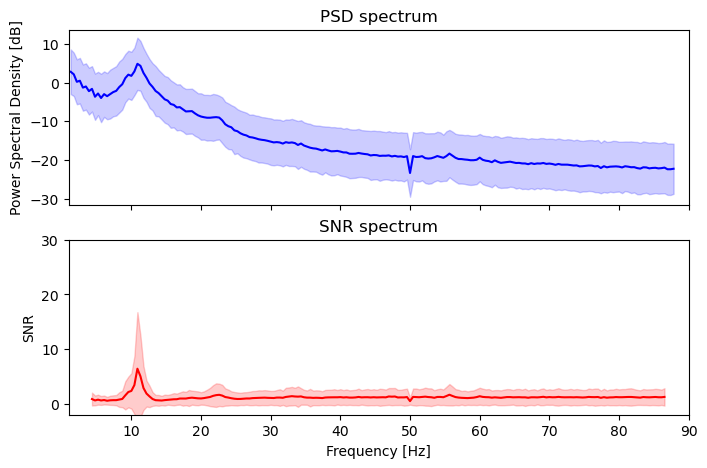

In [8]:
%matplotlib inline
fig, axes = plt.subplots(2, 1, sharex="all", sharey="none", figsize=(8, 5))
freq_range = range(
    np.where(np.floor(freqs) == 1.0)[0][0], np.where(np.ceil(freqs) == fmax - 1)[0][0]
)

psds_plot = 10 * np.log10(psds)
psds_mean = psds_plot.mean(axis=(0, 1))[freq_range]
psds_std = psds_plot.std(axis=(0, 1))[freq_range]
axes[0].plot(freqs[freq_range], psds_mean, color="b")
axes[0].fill_between(
    freqs[freq_range], psds_mean - psds_std, psds_mean + psds_std, color="b", alpha=0.2
)
axes[0].set(title="PSD spectrum", ylabel="Power Spectral Density [dB]")

# SNR spectrum
snr_mean = snrs.mean(axis=(0, 1))[freq_range]
snr_std = snrs.std(axis=(0, 1))[freq_range]

axes[1].plot(freqs[freq_range], snr_mean, color="r")
axes[1].fill_between(
    freqs[freq_range], snr_mean - snr_std, snr_mean + snr_std, color="r", alpha=0.2
)
axes[1].set(
    title="SNR spectrum",
    xlabel="Frequency [Hz]",
    ylabel="SNR",
    ylim=[-2, 30],
    xlim=[fmin, fmax],
)
fig.show()

In [9]:
# Extract SNR values at the stimulation frequency
stim_freq1 = 56.0
stim_freq2 = 60.0

# find index of frequency bin closest to stimulation frequency
i_bin_1 = np.argmin(abs(freqs - stim_freq1))
i_bin_2 = np.argmin(abs(freqs - stim_freq2))

# Apply the subset
snrs_target1 = snrs[:, :, i_bin_1]
snrs_target2 = snrs[:, :, i_bin_2]
print(f'SNR at {stim_freq1}Hz: {snrs_target1.mean()}')
print(f'SNR at {stim_freq2}Hz: {snrs_target2.mean()}')


SNR at 56.0Hz: 1.4313937990968728
SNR at 60.0Hz: 1.3836418508637507


## 1.2 Topography of the SNR

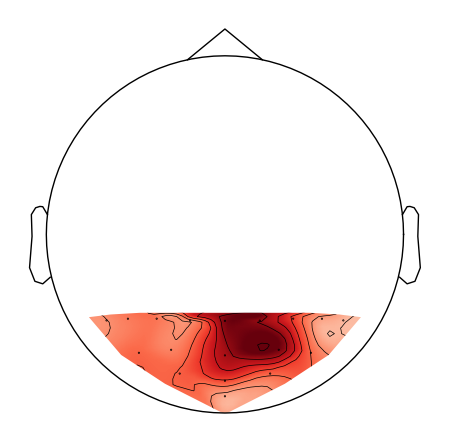

/tmp/ipykernel_15826/2983883592.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


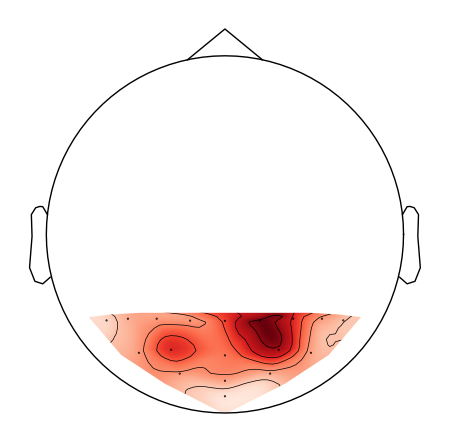

/tmp/ipykernel_15826/2983883592.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [10]:
# get average SNR for each channel
snrs_1_chaverage = snrs_target1.mean(axis=0)
snrs_2_chaverage = snrs_target2.mean(axis=0)

# plot SNR topography
fig, ax = plt.subplots(1)
mne.viz.plot_topomap(snrs_1_chaverage, epochs.info, vlim=(1, None), axes=ax, extrapolate='local')
fig.show()
fig, ax = plt.subplots(1)
mne.viz.plot_topomap(snrs_2_chaverage, epochs.info, vlim=(1, None), axes=ax, extrapolate='local')
fig.show()

## 1.3 Cross-correlation

(0.0, 50.0)

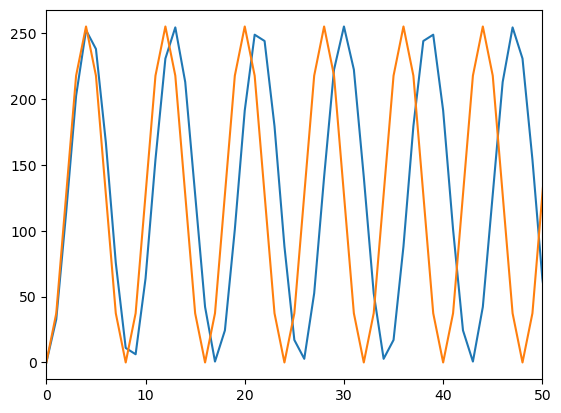

In [82]:
# Reproduce experimental frequency tags
def generate_freq_tag(tag_frequency):
    total_time = 10
    fps_q = 480 * 4
    lcm_fs = 8 * 120
    freq = tag_frequency
    
    if freq == 60 :
        flickers = (np.sin(np.linspace(-np.pi/2, 3*np.pi/2, 9)) + 1) / 2 
        tex_num = 8 
    elif freq == 56 : 
        flickers = (np.sin(np.linspace(-np.pi/2, -np.pi/2 + 14*2*np.pi, 121)) + 1) / 2 
        tex_num = 120
    else : raise ValueError('Tag frequency')
    
    flicker_signal = flickers[:-1]
    sin_wave_vals = np.tile(flicker_signal, (1, np.ceil(total_time * fps_q / tex_num).astype(int)))
    sin_wave_vals = sin_wave_vals[0][:-(len(sin_wave_vals[0]) % lcm_fs)] if (len(sin_wave_vals[0]) % lcm_fs) != 0 else sin_wave_vals[0]
    
    # Scaling luminance levels
    return sin_wave_vals * 255

# Visual check
plt.plot(generate_freq_tag(56))
plt.plot(generate_freq_tag(60))
plt.xlim(0,50)

# 2. Noise tagging condition

In [11]:
f = sio.loadmat(f'{data_path}{data_file}')
noise_stims = f['data']['noise_stims'][0][0] # block x trial x sequences (L or R tag) x timepoints
# Filter out practice trials
noise_stims = noise_stims[1:,:,:,:]

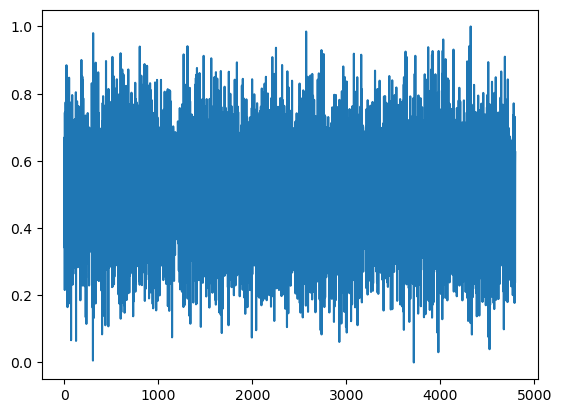

In [12]:
# White noise block 15 trial 32, first tag
plt.plot(noise_stims[14,31,0,:].T)

In [13]:
# Collapse to trial indexes
original_shape = noise_stims.shape
new_shape = (original_shape[0] * original_shape[1],) + original_shape[2:]
noise_stims_tr = np.reshape(noise_stims, new_shape)

# Filter out trials excluded during pre-processing
good_trials_set = pd_info['trial_number'].astype(int).values-1
noise_stims_tr = noise_stims_tr[good_trials_set, :, :]
